In [19]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.simplefilter("ignore", UserWarning)

import geopandas as gpd
# from geodatasets import get_path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import silhouette_score

from create_dataframe import create_warming_df
from kmeans_functions import create_graph

import seaborn as sns

## Details:

- Climate Change Indicator measured yearly 1961 --> 2022
- Codes ISO2 and ISO3: Country codes, 2 and 3 letter

## Removed Columns
- (ISO2): Two-letter code, removed because 3 letter is more readable
- (Indicator): Temperature change with respect to a baseline climatology, corresponding to the period 1951-1980
- (Unit): Degree Celsius
- (Source): Food and Agriculture Organization of the United Nations (FAO). 2022. FAOSTAT Climate Change, Climate Indicators, Temperature change. License: CC BY-NC-SA 3.0 IGO. Extracted from:https://www.fao.org/faostat/en/#data/ET. Accessed on 2023-03-28.
- (CTS_Code): ECCS = Electrical, Communications, and Cyber Systems. CTS Code is how they are represented. Not sure what the relivence of this is
- (CTS_Full_Descriptor): Environment, Climate Change, Climate Indicators, Surface Temperature Change

- [Climate dataset](https://www.kaggle.com/datasets/tarunrm09/climate-change-indicators)
- [Country and City Dataset](https://www.kaggle.com/datasets/liewyousheng/geolocation?select=countries.csv)
- [Pre 1960 Temp Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCountry.csv)

### Possible ways to break the data up:

- Total dataset
- Northern/Southern hemisphere
- Continent
- What models should I pick?
- What division of the model is the best (cross validation, k folds)
- Are there other datasets that I could compare/contrast with?
- crop yields, water levels, population increase, sales of cars?
- What am I trying to find/prove here? 
- Identifying trends?
- Is it possible to train a model here and use it to identify where the data might be pulled from?
- Look at how weather changes might differ depending on region?
- Logistic regression for trends, SVC for identifying similarities between rows? (clustering)

### Things to talk about:
- Coastline Paradox

### THINGS TO DO:
- Add geopandas visualization to kmeans norm and kmeans PCA to see the results!
- Time Series: use DBA!
- Compare results! Especially when using more than 2 clustering points for k means model
- Add 3 and 4 clusters to PCA model. See how results compare to reg kmeans
- Is there a way to add more weight to a single column? (YES! Multiply the value after normalzing the data!)
- Look into Neural Network implementations
- Add 3D graph to kmeans_functions
- Look at manually removing columns to see effect
- Look at results
- Add pca reduction to Time Series

### START DRAWING RESULTS!


In [20]:
def find_dropped_rows(df1, df2):
    df = pd.merge(df1, df2, on='name', indicator=True, how='outer')
    return df[df['_merge'] != 'both']

In [21]:
def world_map(df1):
    # Getting world map data from geo pandas
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot()
    
    df1.plot(
        column='pop_est',
        legend=True,
        ax=ax,
        cmap="YlGnBu",
        alpha=0.5
    )
     
    # turn off axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()

----

In [22]:
df = create_warming_df()
df.shape

(187, 22)

In [23]:
create_graph(df, 20, 20, df['latitude'], df['longitude'], df['region_id'])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

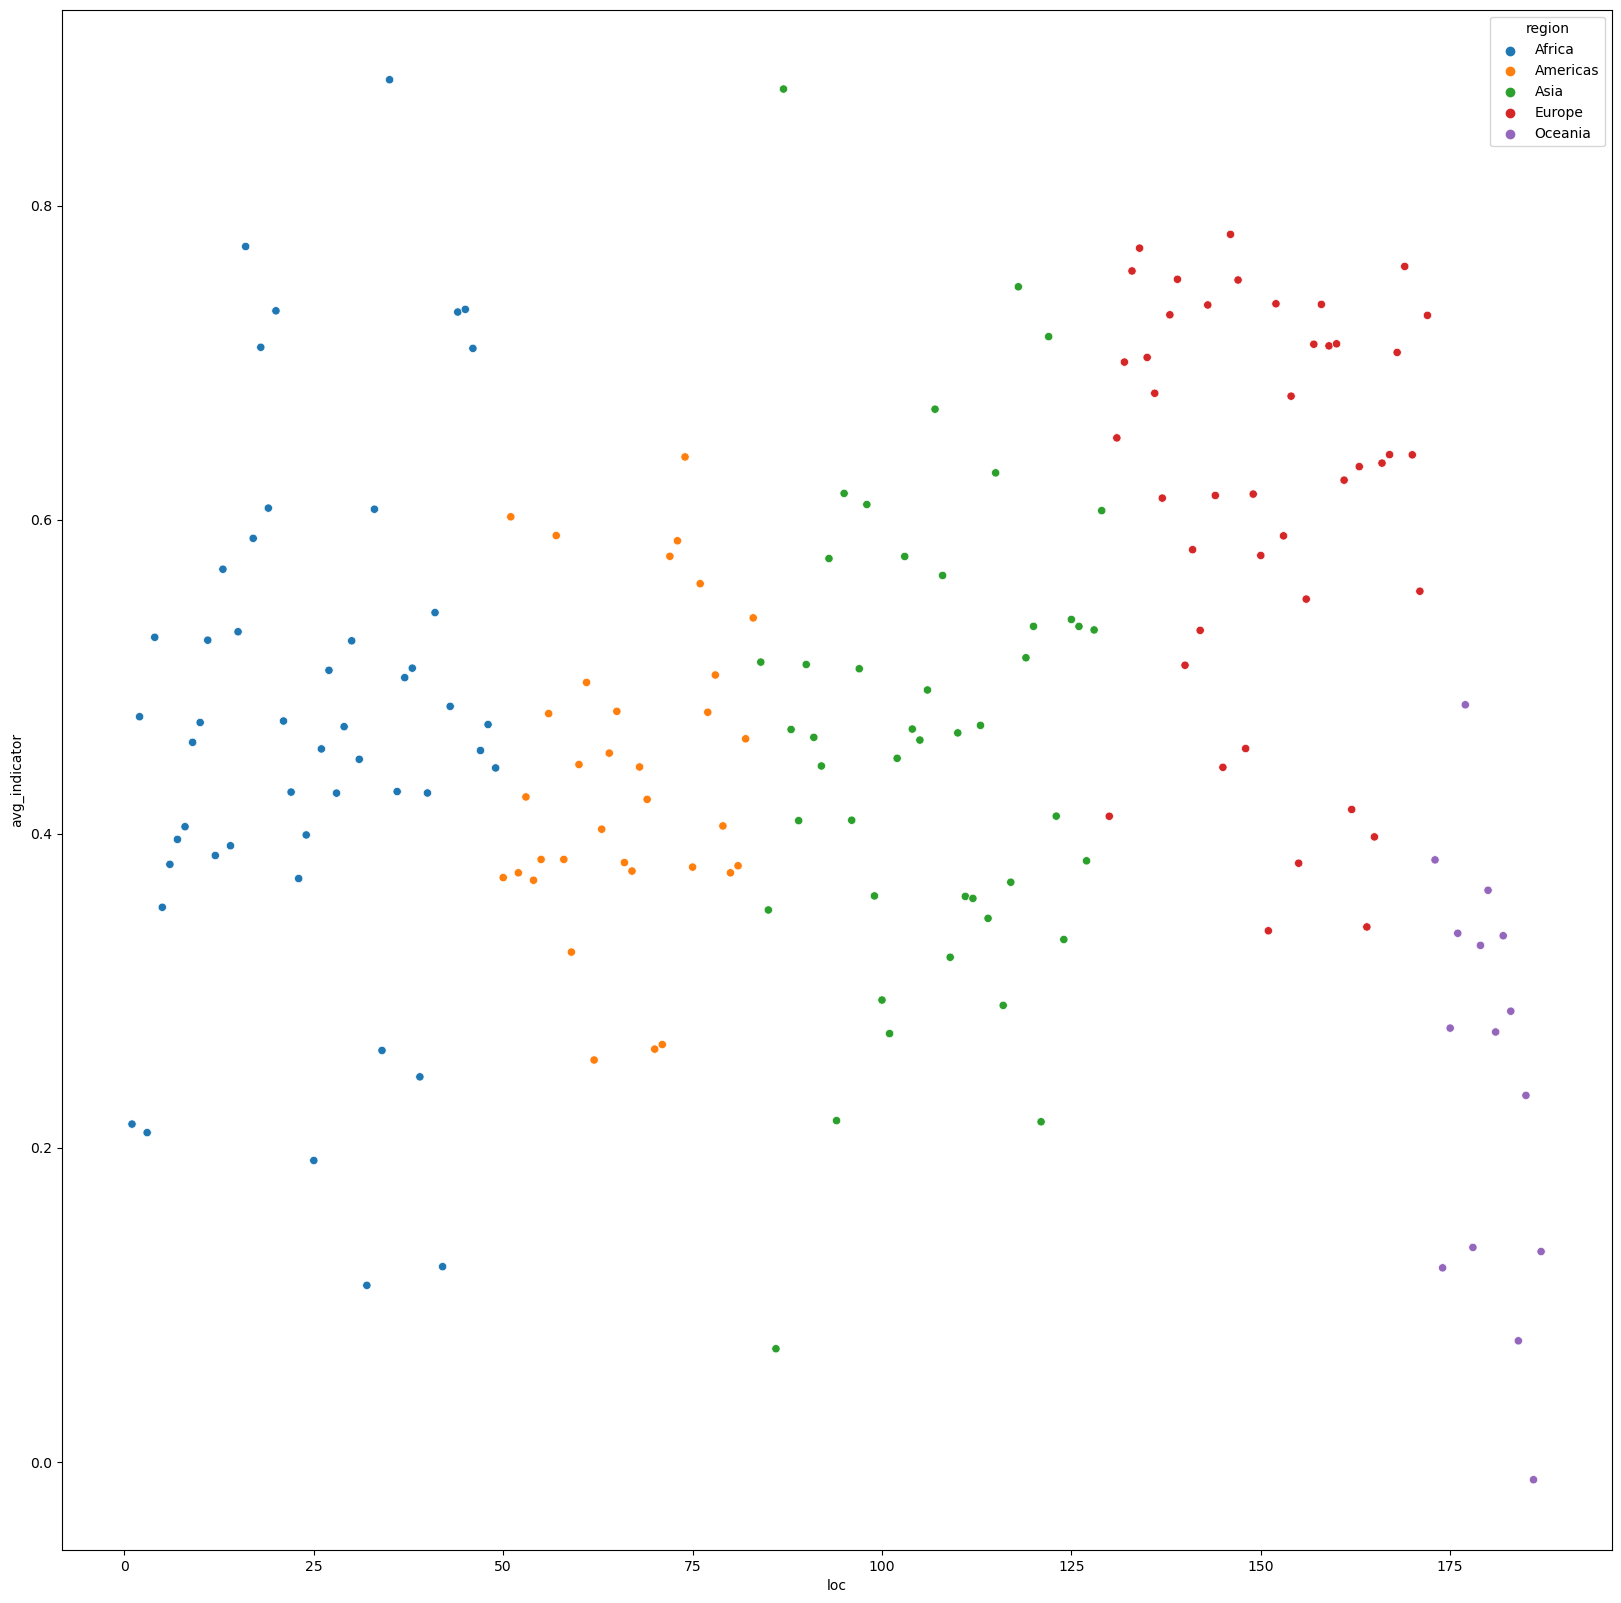

In [24]:
sorted_df = df.loc[:, ['avg_indicator', 'region_id', 'region']]
sorted_df.sort_values(inplace=True, by='region')
sorted_df['loc'] = range(1, len(sorted_df) + 1)

plt.figure(figsize=(20, 20))
sns.scatterplot(data=sorted_df, x="loc", y="avg_indicator", hue="region")
plt.show()

In [25]:
sorted_df = df.loc[:, ['avg_indicator', 'region_id']]
sorted_df.sort_values(inplace=True, by='avg_indicator')
sorted_df['loc'] = range(1, len(sorted_df) + 1)
sorted_df['loc'] = minmax_scale(sorted_df['loc'], feature_range=(0, 1), axis=0, copy=True)
sorted_df['avg_indicator'] = minmax_scale(sorted_df['avg_indicator'], feature_range=(0, 100), axis=0, copy=True)
sorted_df.head()

,avg_indicator,region_id,loc
115,0.000000,3,0.000000
184,9.356327,0,0.005376
122,9.922597,3,0.010753
138,13.882811,2,0.016129
106,15.134857,3,0.021505


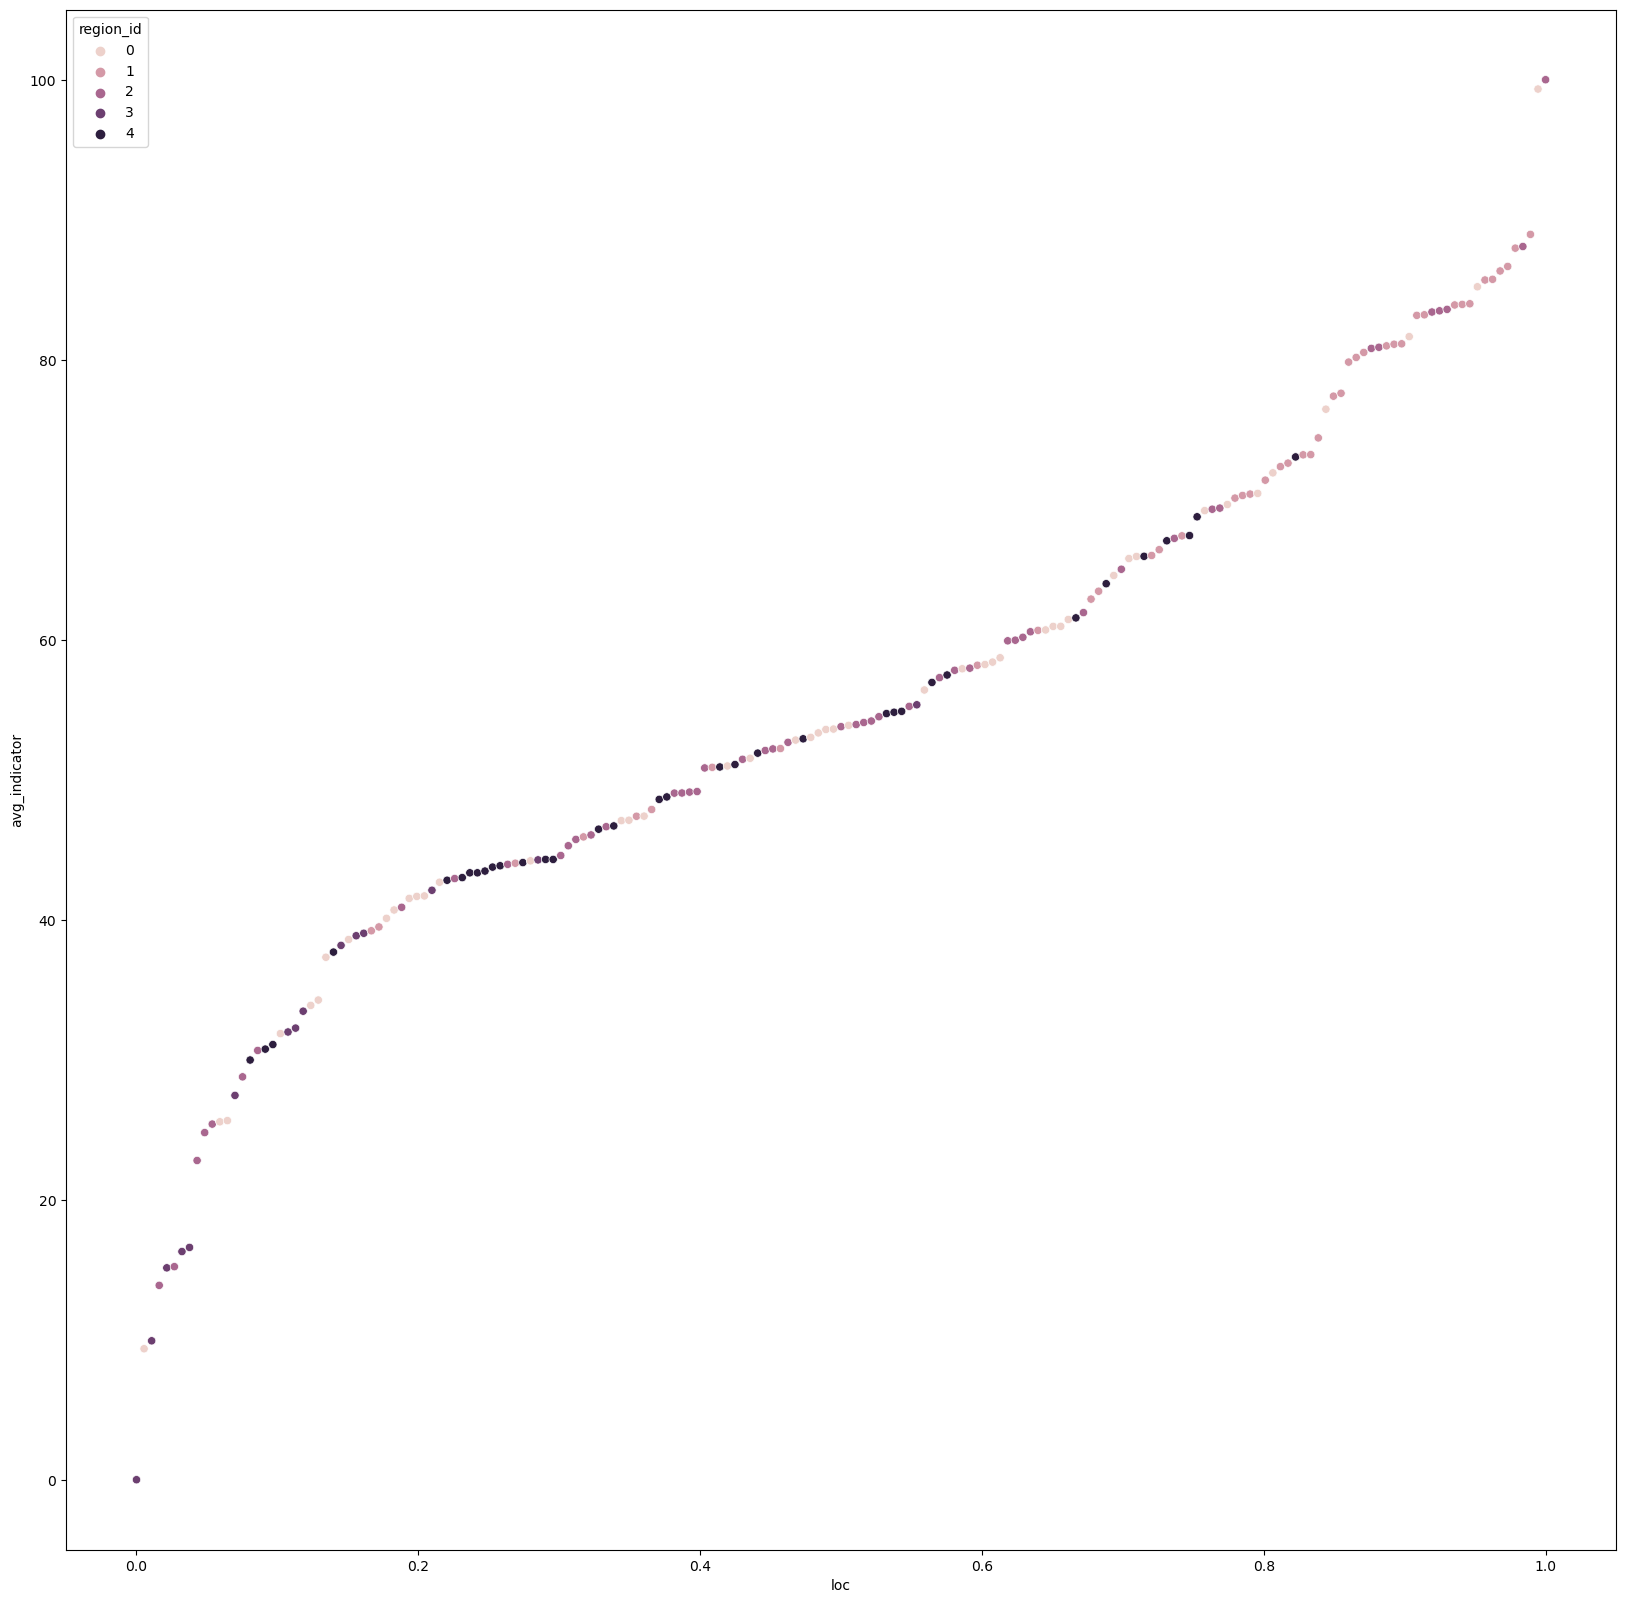

In [26]:
plt.figure(figsize=(20, 20))
sns.scatterplot(data=sorted_df, x="loc", y="avg_indicator", hue="region_id")
plt.show()

In [27]:
# Reduce dimensions to 3 for dataset
# X is the dataset we will be running our algorithm on
X = warming_df.loc[:, ['avg_indicator','latitude', 'longitude']]

NameError: name 'warming_df' is not defined

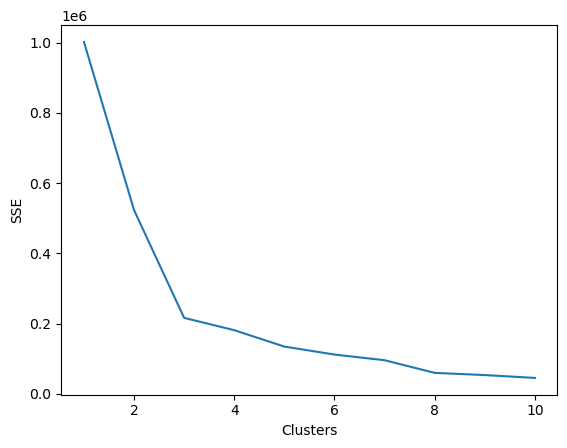

In [28]:
# Elbow method for determining number of clusters. Temp method, may be changed later
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters = i, init='k-means++', random_state = 0, n_init='auto').fit(X)
    wcss.append(k_means.inertia_)
    
#plot elbow curve
plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [29]:
# Create k means model with 5 initial clusters using k-means++ for the starting point choice
# Originally ran with 3 WHICH WAS MORE ACCURATE
kmeans = KMeans(n_clusters = 3, random_state = 0, init= 'k-means++', n_init='auto').fit(X)
y_kmeans = kmeans.fit_predict(X)

# Add the cluster classification to the original dataset
warming_df['cluster'] = y_kmeans

NameError: name 'warming_df' is not defined

In [30]:
# Get the silhouette score
score = silhouette_score(X, y_kmeans)
score

0.5599987630222656

In [31]:
kmeans.cluster_centers_

array([[  0.38893255,  11.35      , 122.63952381],
       [  0.52732931,  25.96140351,  23.59561403],
       [  0.41618378,   5.09736842, -82.65043859]])

In [32]:
# What this graph is showing is that, RIGHT NOW, our data is being classified by LOGITUDE
# NOT BY WARMING RATE
# UNCOMMENT THIS TO CREATE AN INTERACTIVE GRAPH
# %matplotlib notebook
# Documentation https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.scatter.html#mpl_toolkits.mplot3d.axes3d.Axes3D.scatter
# Data visualization: Store the data clusters in three dataframes
data1 = warming_df[warming_df.cluster==0]
data2 = warming_df[warming_df.cluster==1]
data3 = warming_df[warming_df.cluster==2]
# data4 = warming_df[warming_df.cluster==3]
# data5 = warming_df[warming_df.cluster==4]
    
# Create the figure and label all three axis
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Latitude", fontsize=15)
ax.set_zlabel('Warming Rate', fontsize=15, rotation = 0)

# Data for three-dimensional scattered points
# TODO: Change the way the data is assigned here 
ax.scatter3D(data1.longitude, data1.latitude, data1.avg_indicator, c='red', label = 'Cluster 1')
ax.scatter3D(data2.longitude, data2.latitude, data2.avg_indicator, c ='green', label = 'Cluster 2')
ax.scatter3D(data3.longitude, data3.latitude, data3.avg_indicator, c ='blue', label = 'Cluster 3')
# ax.scatter3D(data4.longitude, data4.latitude, data4.avg_indicator, c ='orange', label = 'Cluster 4')
# ax.scatter3D(data5.longitude, data5.latitude, data5.avg_indicator, c ='purple', label = 'Cluster 5')

# Plot the k_means initial cluster points
sizes = np.array([100,100])

# This causes the Runtime warning because one of the cluster points has a negative value (the longitude)
# Removed the first row because of this
plt.scatter(kmeans.cluster_centers_[1:,0], kmeans.cluster_centers_[1:,1], kmeans.cluster_centers_[1:,2], color = 'black')
# plt.legend()
plt.title("K Means")


NameError: name 'warming_df' is not defined

In [ ]:
kmeans.cluster_centers_[1:,2]